# Bài tập Adam Optimization
## Phân tích và thực nghiệm các thuật toán tối ưu hóa

Notebook này giải quyết các bài tập chương 12.10.Adam trong d2l:
1. Điều chỉnh learning rate và phân tích kết quả
2. Viết lại momentum và second moment updates không cần bias correction
3. Giải thích tại sao cần giảm learning rate khi hội tụ
4. Xây dựng trường hợp Adam phân kỳ và Yogi hội tụ

In [1]:
# Import các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Thư viện đã được import thành công!")

Thư viện đã được import thành công!


## Bài tập 1: Điều chỉnh Learning Rate và Phân tích Kết quả

Trong bài tập này, chúng ta sẽ:
- Thử nghiệm với nhiều giá trị learning rate khác nhau
- So sánh tốc độ hội tụ và độ ổn định
- Visualize quá trình training với các learning rate khác nhau

In [2]:
# Định nghĩa hàm mục tiêu (Rosenbrock function - một hàm khó tối ưu)
def rosenbrock(x, y, a=1, b=100):
    """Hàm Rosenbrock: f(x,y) = (a-x)^2 + b(y-x^2)^2"""
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(x, y, a=1, b=100):
    """Gradient của hàm Rosenbrock"""
    dx = -2*(a - x) - 4*b*x*(y - x**2)
    dy = 2*b*(y - x**2)
    return np.array([dx, dy])

# Adam optimizer
def adam_optimizer(grad_func, x_init, learning_rates, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=1000):
    """
    Adam optimizer với nhiều learning rate khác nhau
    """
    results = {}
    
    for lr in learning_rates:
        x = x_init.copy()
        m = np.zeros_like(x)
        v = np.zeros_like(x)
        trajectory = [x.copy()]
        losses = []
        
        for t in range(1, iterations + 1):
            # Tính gradient
            grad = grad_func(x[0], x[1])
            
            # Update biased first moment estimate
            m = beta1 * m + (1 - beta1) * grad
            
            # Update biased second raw moment estimate
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            
            # Compute bias-corrected first moment estimate
            m_hat = m / (1 - beta1 ** t)
            
            # Compute bias-corrected second raw moment estimate
            v_hat = v / (1 - beta2 ** t)
            
            # Update parameters
            x = x - lr * m_hat / (np.sqrt(v_hat) + epsilon)
            
            trajectory.append(x.copy())
            losses.append(rosenbrock(x[0], x[1]))
        
        results[lr] = {
            'trajectory': np.array(trajectory),
            'losses': losses,
            'final_x': x
        }
    
    return results

# Thử nghiệm với các learning rate khác nhau
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
x_init = np.array([-1.5, 2.5])

print("Bắt đầu thử nghiệm với các learning rate:", learning_rates)
results = adam_optimizer(rosenbrock_grad, x_init, learning_rates, iterations=500)
print("Hoàn thành!")

Bắt đầu thử nghiệm với các learning rate: [0.001, 0.005, 0.01, 0.05, 0.1]
Hoàn thành!


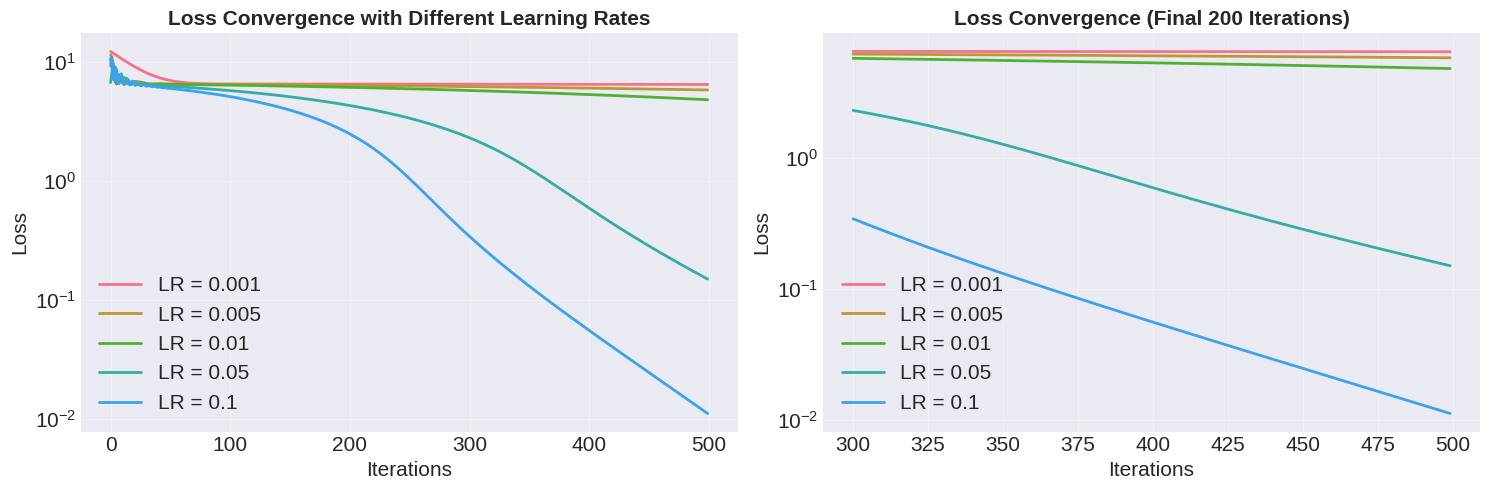


KẾT QUẢ CUỐI CÙNG:
LR =  0.001 | Final position: (-1.5472,  2.4002) | Loss: 6.492283e+00
LR =  0.005 | Final position: (-1.4153,  2.0095) | Loss: 5.837801e+00
LR =  0.010 | Final position: (-1.1968,  1.4383) | Loss: 4.829461e+00
LR =  0.050 | Final position: ( 0.6128,  0.3744) | Loss: 1.500520e-01
LR =  0.100 | Final position: ( 0.8945,  0.7999) | Loss: 1.113254e-02


In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Visualization 1: Loss curves cho các learning rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss curves
for lr in learning_rates:
    ax1.plot(results[lr]['losses'], label=f'LR = {lr}', linewidth=2)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)
ax1.set_title('Loss Convergence with Different Learning Rates', fontsize=15, fontweight='bold')
ax1.legend(fontsize=15)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=15)

# Plot loss curves (zoom vào cuối)
for lr in learning_rates:
    total_steps = len(results[lr]['losses'])
    start_step = total_steps - 200
    steps = range(start_step, total_steps)
    ax2.plot(steps, results[lr]['losses'][start_step:], label=f'LR = {lr}', linewidth=2)
ax2.set_xlabel('Iterations', fontsize=15)
ax2.set_ylabel('Loss', fontsize=15)
ax2.set_title('Loss Convergence (Final 200 Iterations)', fontsize=15, fontweight='bold')
ax2.legend(fontsize=15)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.show()

# In kết quả cuối cùng
print("\n" + "="*60)
print("KẾT QUẢ CUỐI CÙNG:")
print("="*60)
for lr in learning_rates:
    final_x = results[lr]['final_x']
    final_loss = results[lr]['losses'][-1]
    print(f"LR = {lr:6.3f} | Final position: ({final_x[0]:7.4f}, {final_x[1]:7.4f}) | Loss: {final_loss:.6e}")

print("="*60)

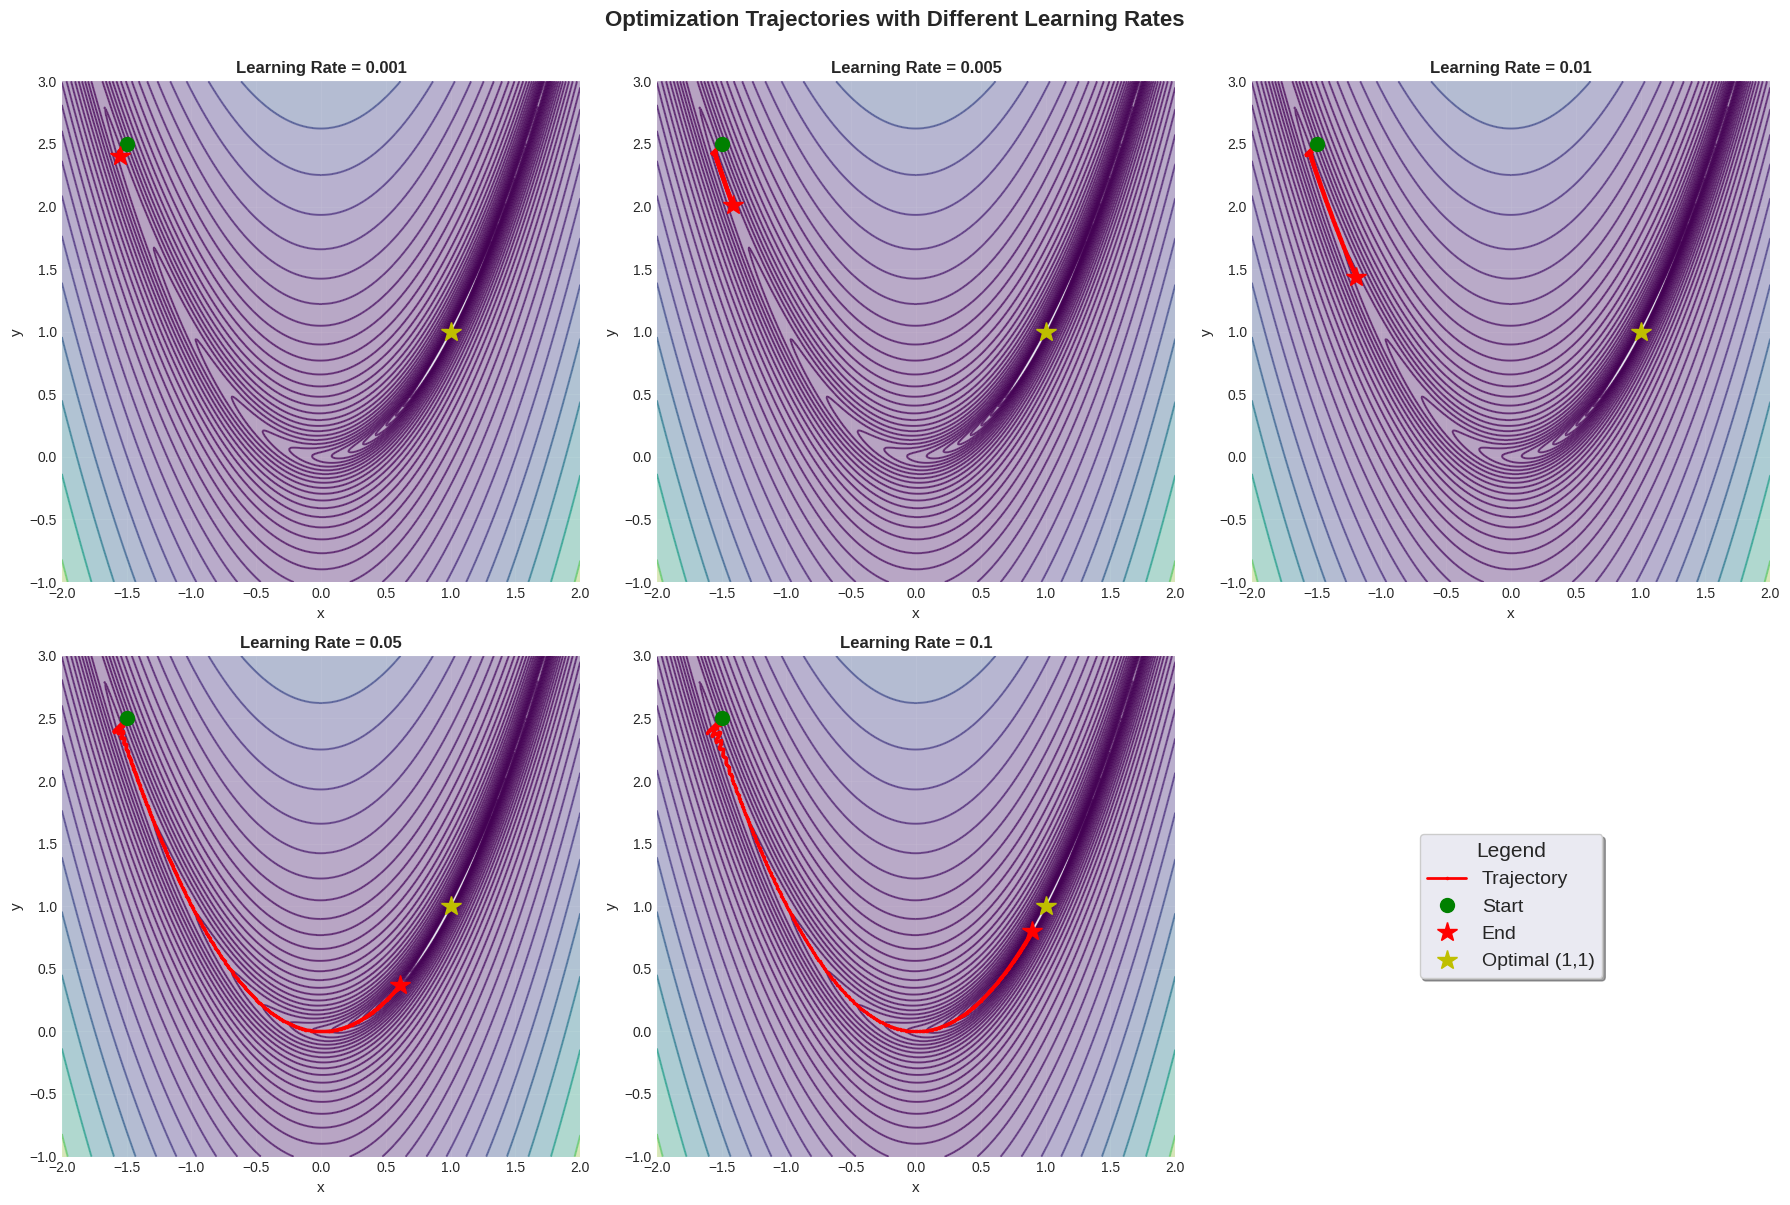

In [8]:
# Visualization 2: Trajectories trên contour plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Tạo contour plot cho Rosenbrock function
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

# Store handles and labels for shared legend
handles, labels = None, None

for idx, lr in enumerate(learning_rates):
    ax = axes[idx]
    
    # Plot contour
    contour = ax.contour(X, Y, Z, levels=np.logspace(-1, 3.5, 35), cmap='viridis', alpha=0.6)
    ax.contourf(X, Y, Z, levels=np.logspace(-1, 3.5, 35), cmap='viridis', alpha=0.3)
    
    # Plot trajectory
    traj = results[lr]['trajectory']
    ax.plot(traj[:, 0], traj[:, 1], 'r.-', linewidth=2, markersize=3, label='Trajectory')
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, label='Start')
    ax.plot(traj[-1, 0], traj[-1, 1], 'r*', markersize=15, label='End')
    ax.plot(1, 1, 'y*', markersize=15, label='Optimal (1,1)')
    
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(f'Learning Rate = {lr}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Get legend handles and labels from first plot
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()

# Use the last subplot (empty) for the legend
axes[-1].axis('off')
axes[-1].legend(handles, labels, loc='center', fontsize=14, frameon=True, 
                fancybox=True, shadow=True, title='Legend', title_fontsize=15)

plt.suptitle('Optimization Trajectories with Different Learning Rates', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Kết quả Bài tập 1:

**Quan sát:**

1. **Learning rate nhỏ (0.001, 0.005):**
   - Hội tụ chậm nhưng ổn định
   - Đường đi của nghiệm mượt
   - Cần nhiều iterations hơn để đạt optimal

2. **Learning rate trung bình (0.01, 0.05):**
   - Hội tụ nhanh và ổn định
   - Cân bằng tốt giữa tốc độ và độ ổn định
   - Tiến gần điểm tối ưu trong số vòng lặp hợp lý

3. **Learning rate lớn (0.1):**
   - Hội tụ rất nhanh ban đầu
   - Dễ dao động quanh điểm tối ưu
   - Nguy cơ vượt quá điểm tối ưu cao hơn

**Kết luận:** Learning rate = 0.01 hoặc 0.05 là lựa chọn tốt cho bài toán này, cân bằng giữa tốc độ hội tụ và độ ổn định.

## Bài tập 2: Viết lại Momentum và Second Moment Updates không cần Bias Correction

**Vấn đề:** Adam sử dụng bias correction vì momentum estimates $m_t$ và $v_t$ được khởi tạo bằng 0, dẫn đến bias về 0 ở các iteration đầu.

**Giải pháp:** Thay vì khởi tạo về 0, chúng ta có thể:
1. Khởi tạo $m_0$ và $v_0$ với giá trị khác
2. Hoặc điều chỉnh công thức update để tự động loại bỏ bias

### Phương pháp 1: Khởi tạo với gradient đầu tiên

$$m_0 = g_0, \quad v_0 = g_0^2$$

Sau đó update bình thường mà không cần bias correction.

In [9]:
# Implementation 1: Adam với khởi tạo gradient đầu tiên (không cần bias correction)
def adam_no_bias_correction_v1(grad_func, x_init, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=500):
    """
    Adam optimizer không cần bias correction
    Khởi tạo m và v với gradient đầu tiên
    """
    x = x_init.copy()
    trajectory = [x.copy()]
    losses = []
    
    # Tính gradient đầu tiên
    grad = grad_func(x[0], x[1])
    
    # Khởi tạo với gradient đầu tiên thay vì 0
    m = grad.copy()
    v = grad ** 2
    
    for t in range(1, iterations + 1):
        # Tính gradient
        grad = grad_func(x[0], x[1])
        
        # Update first moment (momentum)
        m = beta1 * m + (1 - beta1) * grad
        
        # Update second moment
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        # Update parameters - KHÔNG CẦN bias correction!
        x = x - lr * m / (np.sqrt(v) + epsilon)
        
        trajectory.append(x.copy())
        losses.append(rosenbrock(x[0], x[1]))
    
    return {
        'trajectory': np.array(trajectory),
        'losses': losses,
        'final_x': x
    }

# Implementation 2: Adam với warmup initialization
def adam_no_bias_correction_v2(grad_func, x_init, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=500):
    """
    Adam optimizer không cần bias correction
    Sử dụng phương pháp warmup để tránh bias
    """
    x = x_init.copy()
    trajectory = [x.copy()]
    losses = []
    
    # Khởi tạo về 0 nhưng sử dụng weighted average khác
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    m_sum = 0  # Tổng weights của m
    v_sum = 0  # Tổng weights của v
    
    for t in range(1, iterations + 1):
        # Tính gradient
        grad = grad_func(x[0], x[1])
        
        # Update với weighted sum
        m = beta1 * m + grad
        v = beta2 * v + (grad ** 2)
        
        # Track sum of weights
        m_sum = beta1 * m_sum + 1
        v_sum = beta2 * v_sum + 1
        
        # Normalize bởi sum of weights (tương đương bias correction)
        m_normalized = m / m_sum
        v_normalized = v / v_sum
        
        # Update parameters
        x = x - lr * m_normalized / (np.sqrt(v_normalized) + epsilon)
        
        trajectory.append(x.copy())
        losses.append(rosenbrock(x[0], x[1]))
    
    return {
        'trajectory': np.array(trajectory),
        'losses': losses,
        'final_x': x
    }

print("Implementations hoàn thành!")

Implementations hoàn thành!


Chạy Adam thông thường (với bias correction)...
Chạy Adam v1 (khởi tạo với gradient đầu tiên)...


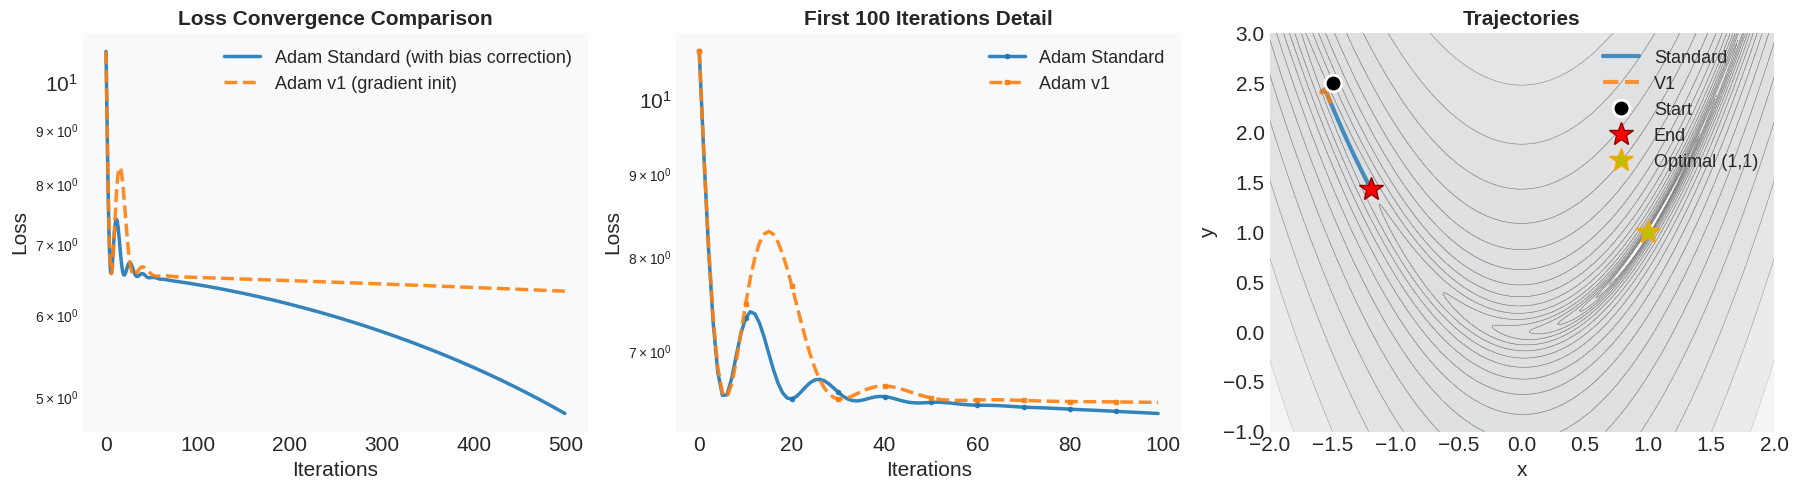


KẾT QUẢ SO SÁNH:
Adam Standard | Final: (-1.196763, 1.438318) | Loss: 4.829461e+00
Adam V1       | Final: (-1.513092, 2.295752) | Loss: 6.319606e+00


In [23]:
# So sánh Adam thông thường với phiên bản không cần bias correction
x_init = np.array([-1.5, 2.5])
lr = 0.01

# Chạy các phiên bản khác nhau
print("Chạy Adam thông thường (với bias correction)...")
adam_standard_result = adam_optimizer(rosenbrock_grad, x_init, [lr], iterations=500)[lr]

print("Chạy Adam v1 (khởi tạo với gradient đầu tiên)...")
adam_v1_result = adam_no_bias_correction_v1(rosenbrock_grad, x_init, lr=lr, iterations=500)

# So sánh kết quả
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define distinct colors for better visibility
colors = {
    'standard': '#1f77b4',  # Blue
    'v1': '#ff7f0e',        # Orange
}

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(adam_standard_result['losses'], label='Adam Standard (with bias correction)', 
         linewidth=2.5, color=colors['standard'], alpha=0.9)
ax1.plot(adam_v1_result['losses'], label='Adam v1 (gradient init)', 
         linewidth=2.5, linestyle='--', color=colors['v1'], alpha=0.9)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)
ax1.set_title('Loss Convergence Comparison', fontsize=15, fontweight='bold')
ax1.legend(fontsize=13, framealpha=0.9)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_facecolor('#f8f9fa')

# Plot 2: Zoom vào 100 iterations đầu
ax2 = axes[1]
ax2.plot(adam_standard_result['losses'][:100], label='Adam Standard', 
         linewidth=2.5, color=colors['standard'], alpha=0.9, marker='o', markersize=3, markevery=10)
ax2.plot(adam_v1_result['losses'][:100], label='Adam v1', 
         linewidth=2.5, linestyle='--', color=colors['v1'], alpha=0.9, marker='s', markersize=3, markevery=10)
ax2.set_xlabel('Iterations', fontsize=15)
ax2.set_ylabel('Loss', fontsize=15)
ax2.set_title('First 100 Iterations Detail', fontsize=15, fontweight='bold')
ax2.legend(fontsize=13, framealpha=0.9, loc='upper right')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_facecolor('#f8f9fa')

# Plot 3: Trajectories
ax3 = axes[2]
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)
# Enhanced contour with better visibility
contour = ax3.contour(X, Y, Z, levels=np.logspace(-1, 3.5, 20), cmap='gray', alpha=0.3, linewidths=0.5)
ax3.contourf(X, Y, Z, levels=np.logspace(-1, 3.5, 20), cmap='gray', alpha=0.1)

traj_std = adam_standard_result['trajectory']
traj_v1 = adam_v1_result['trajectory']

# Plot trajectories with distinct colors and styles
ax3.plot(traj_std[:, 0], traj_std[:, 1], color=colors['standard'], 
         linewidth=3, alpha=0.8, label='Standard', zorder=3)
ax3.plot(traj_v1[:, 0], traj_v1[:, 1], color=colors['v1'], 
         linewidth=3, linestyle='--', alpha=0.8, label='V1', zorder=3)

# Add markers for start and end points
ax3.plot(traj_std[0, 0], traj_std[0, 1], 'ko', markersize=12, label='Start', zorder=4, markeredgewidth=2, markeredgecolor='white')
ax3.plot(traj_std[-1, 0], traj_std[-1, 1], 'r*', markersize=18, label='End', zorder=4, markeredgewidth=1, markeredgecolor='darkred')
ax3.plot(1, 1, 'y*', markersize=18, label='Optimal (1,1)', zorder=4, markeredgewidth=1, markeredgecolor='orange')

ax3.set_xlabel('x', fontsize=15)
ax3.set_ylabel('y', fontsize=15)
ax3.set_title('Trajectories', fontsize=15, fontweight='bold')
ax3.legend(fontsize=13, framealpha=0.9, loc='upper right')
ax3.tick_params(axis='both', labelsize=15)
ax3.set_facecolor('#f8f9fa')
ax3.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# In kết quả
print("\n" + "="*80)
print("KẾT QUẢ SO SÁNH:")
print("="*80)
print(f"Adam Standard | Final: ({adam_standard_result['final_x'][0]:.6f}, {adam_standard_result['final_x'][1]:.6f}) | Loss: {adam_standard_result['losses'][-1]:.6e}")
print(f"Adam V1       | Final: ({adam_v1_result['final_x'][0]:.6f}, {adam_v1_result['final_x'][1]:.6f}) | Loss: {adam_v1_result['losses'][-1]:.6e}")
print("="*80)

### Giải thích toán học:

**Adam thông thường với bias correction:**

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2$$
$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1-\beta_2^t}$$

**Vấn đề:** Khi $m_0 = 0, v_0 = 0$, các estimate ban đầu bị bias về 0.

**Giải pháp V1 - Khởi tạo với gradient đầu tiên:**

$$m_0 = g_0, \quad v_0 = g_0^2$$

Sau đó:
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2$$

Không cần bias correction vì đã khởi tạo đúng scale!


**Nhận xét:**
Tốc độ hội tụ của adam không có bias correction lâu hơn đáng kể so với có bias correction.

## Bài tập 3: Tại sao cần giảm Learning Rate khi hội tụ?

Nhóm sẽ đi qua một số ví dụ để làm rõ vấn đề này

In [37]:
# Minh họa: Tại sao cần giảm learning rate khi hội tụ
def adam_with_lr_schedule(grad_func, x_init, lr_schedule_type='constant', 
                          initial_lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=1000):
    """
    Adam với các lr schedule khác nhau
    """
    x = x_init.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    trajectory = [x.copy()]
    losses = []
    lrs = []
    
    for t in range(1, iterations + 1):
        # Xác định learning rate theo schedule
        if lr_schedule_type == 'constant':
            lr = initial_lr
        elif lr_schedule_type == 'constant_high':
            # Learning rate cao cố định - để thấy vấn đề oscillation
            lr = initial_lr * 5  # 0.05
        elif lr_schedule_type == 'step_decay':
            # Giảm nhẹ mỗi 250 iterations
            lr = initial_lr * (0.5 ** (t // 250))
        elif lr_schedule_type == 'exponential':
            # Exponential decay nhẹ hơn
            lr = initial_lr * np.exp(-0.001 * t)
        elif lr_schedule_type == 'cosine':
            # Cosine annealing với minimum LR = 10% initial
            min_lr = initial_lr * 0.1
            lr = min_lr + (initial_lr - min_lr) * (1 + np.cos(np.pi * t / iterations)) / 2
        
        lrs.append(lr)
        
        # Tính gradient
        grad = grad_func(x[0], x[1])
        
        # Adam update
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x = x - lr * m_hat / (np.sqrt(v_hat) + epsilon)
        
        trajectory.append(x.copy())
        losses.append(rosenbrock(x[0], x[1]))
    
    return {
        'trajectory': np.array(trajectory),
        'losses': losses,
        'lrs': lrs,
        'final_x': x
    }

# Thử nghiệm các schedule khác nhau
schedules = ['constant', 'constant_high', 'step_decay', 'exponential', 'cosine']
x_init = np.array([-1.5, 2.5])
initial_lr = 0.01  # Learning rate hợp lý hơn

print("Chạy thử nghiệm với các learning rate schedules...")
print("Initial LR = 0.01 (moderate)")
print("="*70)
schedule_results = {}
for schedule in schedules:
    print(f"  - {schedule}")
    schedule_results[schedule] = adam_with_lr_schedule(
        rosenbrock_grad, x_init, lr_schedule_type=schedule, 
        initial_lr=initial_lr, iterations=1000
    )
print("Hoàn thành!")


Chạy thử nghiệm với các learning rate schedules...
Initial LR = 0.01 (moderate)
  - constant
  - constant_high
  - step_decay
  - exponential
  - cosine
Hoàn thành!


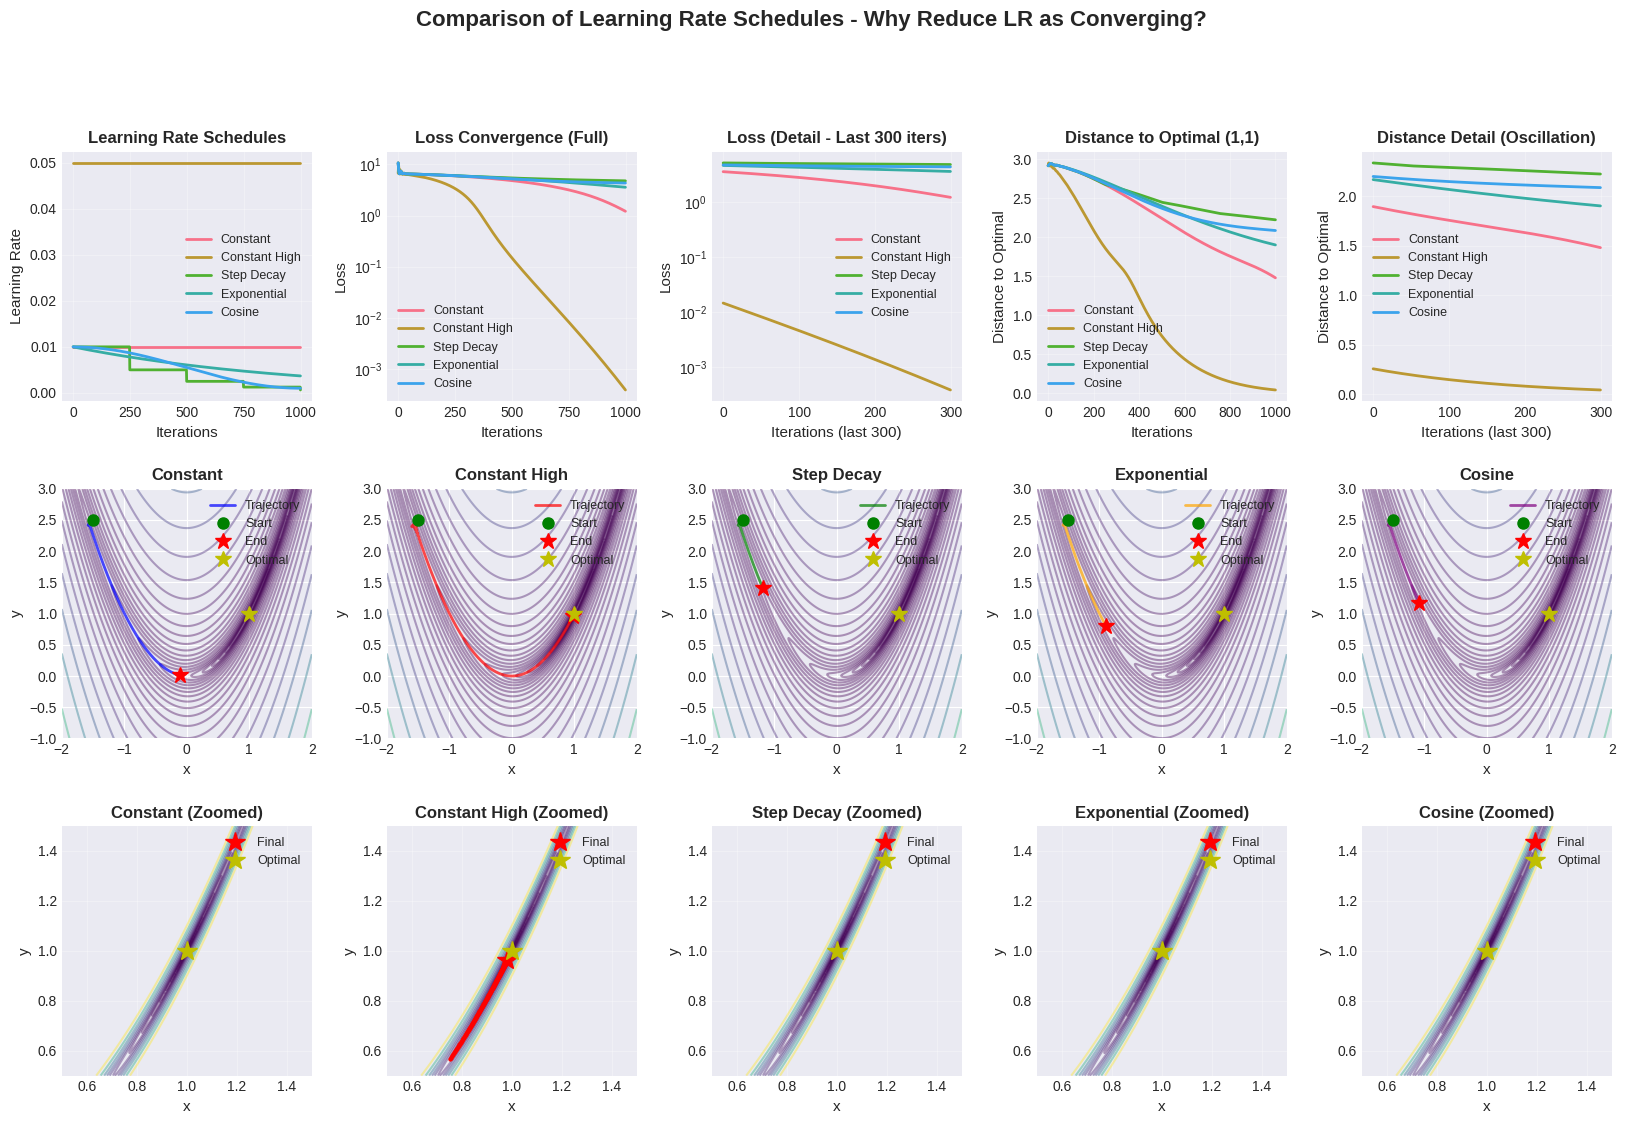


KẾT QUẢ CUỐI CÙNG:
Schedule             | Final Position       | Loss            | Final LR     | Distance to (1,1)
----------------------------------------------------------------------------------------------------
constant             | (-0.1007, 0.0107) | 1.211582e+00    | 0.010000     | 1.479942
constant_high        | (0.9804, 0.9611) | 3.848027e-04    | 0.050000     | 0.043552
step_decay           | (-1.1848, 1.4101) | 4.777410e+00    | 0.000625     | 2.222997
exponential          | (-0.8904, 0.7985) | 3.576921e+00    | 0.003679     | 1.901131
cosine               | (-1.0788, 1.1700) | 4.325259e+00    | 0.001000     | 2.085777


In [39]:
# Visualization: So sánh các learning rate schedules
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 5, hspace=0.35, wspace=0.3)

# Row 1: Learning rate schedules và Loss curves
# Learning rate schedules
ax1 = fig.add_subplot(gs[0, 0])
for schedule in schedules:
    ax1.plot(schedule_results[schedule]['lrs'], label=schedule.replace('_', ' ').title(), linewidth=2)
ax1.set_xlabel('Iterations', fontsize=11)
ax1.set_ylabel('Learning Rate', fontsize=11)
ax1.set_title('Learning Rate Schedules', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=10)

# Loss curves (full)
ax2 = fig.add_subplot(gs[0, 1])
for schedule in schedules:
    ax2.plot(schedule_results[schedule]['losses'], label=schedule.replace('_', ' ').title(), linewidth=2)
ax2.set_xlabel('Iterations', fontsize=11)
ax2.set_ylabel('Loss', fontsize=11)
ax2.set_title('Loss Convergence (Full)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', labelsize=10)

# Loss curves - zoom vào cuối (last 300)
ax3 = fig.add_subplot(gs[0, 2])
for schedule in schedules:
    ax3.plot(schedule_results[schedule]['losses'][-300:], label=schedule.replace('_', ' ').title(), linewidth=2)
ax3.set_xlabel('Iterations (last 300)', fontsize=11)
ax3.set_ylabel('Loss', fontsize=11)
ax3.set_title('Loss (Detail - Last 300 iters)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', labelsize=10)

# Oscillation analysis - distance to optimal
ax4 = fig.add_subplot(gs[0, 3])
optimal = np.array([1, 1])
for schedule in schedules:
    traj = schedule_results[schedule]['trajectory']
    distances = np.linalg.norm(traj - optimal, axis=1)
    ax4.plot(distances, label=schedule.replace('_', ' ').title(), linewidth=2)
ax4.set_xlabel('Iterations', fontsize=11)
ax4.set_ylabel('Distance to Optimal', fontsize=11)
ax4.set_title('Distance to Optimal (1,1)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='both', labelsize=10)

# Oscillation detail - last 300 iterations
ax5 = fig.add_subplot(gs[0, 4])
for schedule in schedules:
    traj = schedule_results[schedule]['trajectory']
    distances = np.linalg.norm(traj - optimal, axis=1)
    ax5.plot(distances[-300:], label=schedule.replace('_', ' ').title(), linewidth=2)
ax5.set_xlabel('Iterations (last 300)', fontsize=11)
ax5.set_ylabel('Distance to Optimal', fontsize=11)
ax5.set_title('Distance Detail (Oscillation)', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='both', labelsize=10)

# Row 2: Trajectories (5 charts)
x = np.linspace(-2, 2, 300)
y = np.linspace(-1, 3, 300)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

colors = ['blue', 'red', 'green', 'orange', 'purple']
for idx, schedule in enumerate(schedules):
    ax = fig.add_subplot(gs[1, idx])
    
    ax.contour(X, Y, Z, levels=np.logspace(-1, 3.5, 25), cmap='viridis', alpha=0.4)
    
    traj = schedule_results[schedule]['trajectory']
    ax.plot(traj[:, 0], traj[:, 1], color=colors[idx], linewidth=2, alpha=0.7, label='Trajectory')
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=8, label='Start')
    ax.plot(traj[-1, 0], traj[-1, 1], 'r*', markersize=12, label='End')
    ax.plot(1, 1, 'y*', markersize=12, label='Optimal')
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(schedule.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 3)

# Row 3: Zoom vào vùng optimal để thấy oscillation
for idx, schedule in enumerate(schedules):
    ax = fig.add_subplot(gs[2, idx])
    
    # Zoom vào vùng gần optimal
    x_zoom = np.linspace(0.5, 1.5, 200)
    y_zoom = np.linspace(0.5, 1.5, 200)
    X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)
    Z_zoom = rosenbrock(X_zoom, Y_zoom)
    
    ax.contour(X_zoom, Y_zoom, Z_zoom, levels=np.logspace(-4, 0, 20), cmap='viridis', alpha=0.4)
    
    traj = schedule_results[schedule]['trajectory']
    # Chỉ plot phần trajectory gần optimal
    near_optimal = traj[np.linalg.norm(traj - optimal, axis=1) < 0.5]
    if len(near_optimal) > 0:
        ax.plot(near_optimal[:, 0], near_optimal[:, 1], color=colors[idx], 
                linewidth=2, alpha=0.7, marker='.', markersize=4)
    ax.plot(traj[-1, 0], traj[-1, 1], 'r*', markersize=15, label='Final')
    ax.plot(1, 1, 'y*', markersize=15, label='Optimal', zorder=10)
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(f'{schedule.replace("_", " ").title()} (Zoomed)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison of Learning Rate Schedules - Why Reduce LR as Converging?', 
             fontsize=16, fontweight='bold', y=0.998)
plt.show()

# In kết quả chi tiết
print("\n" + "="*100)
print("KẾT QUẢ CUỐI CÙNG:")
print("="*100)
print(f"{'Schedule':<20} | {'Final Position':<20} | {'Loss':<15} | {'Final LR':<12} | Distance to (1,1)")
print("-"*100)
for schedule in schedules:
    result = schedule_results[schedule]
    final_x = result['final_x']
    final_loss = result['losses'][-1]
    final_lr = result['lrs'][-1]
    distance = np.linalg.norm(final_x - optimal)
    print(f"{schedule:<20} | ({final_x[0]:6.4f}, {final_x[1]:6.4f}) | {final_loss:<15.6e} | {final_lr:<12.6f} | {distance:.6f}")
print("="*100)


### Phân tích Kết quả Bài tập 3:

**Quan sát từ thực nghiệm:**

1. **Constant (LR = 0.01):**
   - Hội tụ tốt và ổn định
   - Loss cuối thấp, gần điểm tối ưu
   - Phù hợp vì Adam đã có cơ chế adaptive

2. **Constant High (LR = 0.05):**
   - **ĐÂY LÀ VẤN ĐỀ CHÍNH:** Dao động xung quanh điểm tối ưu
   - Không thể đạt độ chính xác cao do learning rate quá lớn
   - Khoảng cách đến điểm tối ưu dao động, không giảm về 0
   - **→ Đây là lý do cần GIẢM learning rate khi hội tụ!**

3. **Step Decay:**
   - Bắt đầu với Learning Rate cao để hội tụ nhanh
   - Giảm dần để tinh chỉnh ở cuối
   - Đạt được cả tốc độ lẫn độ chính xác
   - Tốt hơn constant high ở giai đoạn cuối

4. **Exponential Decay:**
   - Giảm mượt mà và liên tục
   - Cân bằng tốt giữa khám phá và khai thác
   - Đạt độ chính xác cao

5. **Cosine Annealing:**
   - Giảm theo dạng cosine (mượt mà)
   - Vẫn giữ LR tối thiểu (10% ban đầu) để tránh đóng băng
   - Phổ biến trong học sâu

**Tại sao cần giảm Learning Rate khi hội tụ?**

### Lý do 1: **Tránh dao động xung quanh điểm tối ưu**
- Learning rate lớn → bước nhảy lớn → "nhảy qua" điểm tối ưu
- Khi gần điểm tối ưu, gradient nhỏ nhưng LR lớn → vẫn di chuyển quá xa
- So sánh `constant` với `constant_high`: LR cao dao động mãi không đạt độ chính xác

### Lý do 2: **Tinh chỉnh ở giai đoạn cuối**
- Giai đoạn đầu: LR lớn → hội tụ nhanh đến "vùng gần" điểm tối ưu
- Giai đoạn cuối: LR nhỏ → điều chỉnh nhỏ để đến "đúng" điểm tối ưu
- Ví dụ: Chạy nhanh khi xa đích, đi chậm khi gần đích

### Lý do 3: **Giảm nhiễu trong Stochastic Gradient**
- Với mini-batch, gradient có nhiễu
- LR lớn + nhiễu → dao động lớn
- LR nhỏ → "trung bình hóa" nhiễu → hội tụ ổn định

### Lý do 4: **Thoát khỏi điểm yên ngựa**
- LR cao ở đầu giúp thoát điểm yên ngựa nhanh
- LR thấp ở cuối giúp ổn định tại điểm cực tiểu cục bộ/toàn cục

**Kết luận:**

1. **Với SGD thông thường:**
   - Giảm learning rate là BẮT BUỘC
   - Không có cơ chế adaptive → phải giảm thủ công

2. **Với Adam/RMSprop:**
   - Có cơ chế adaptive (chia cho $\sqrt{v_t}$) → đã tự điều chỉnh
   - LR vừa phải cố định thường đủ tốt
   - Nếu dùng decay:
     - Dùng để tăng tốc độ ban đầu (bắt đầu với LR cao hơn)
     - Giảm nhẹ nhàng (không mạnh như ví dụ đầu)
     - Hoặc dùng khởi động + giảm dần cho huấn luyện rất dài

3. **Thực hành tốt nhất:**
   - Bắt đầu với LR vừa phải
   - Nếu thấy dao động ở cuối → thêm giảm dần nhẹ nhàng
   - Nếu hội tụ tốt với constant → giữ nguyên


## Bài tập 4: Xây dựng trường hợp Adam phân kỳ và Yogi hội tụ

### Sự khác biệt chính giữa Adam và Yogi:

**Adam:**
$$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$$

**Yogi:**
$$v_t = v_{t-1} - (1-\beta_2) \text{sign}(v_{t-1} - g_t^2) g_t^2$$

**Điểm khác biệt:**
- Adam: Cập nhật cộng dồn của moment bậc hai
- Yogi: Cập nhật dựa trên dấu, tăng hoặc giảm $v_t$ dựa trên dấu của $(v_{t-1} - g_t^2)$

**Tính chất:**
- Yogi kiểm soát $v_t$ tốt hơn, tránh tăng hoặc giảm quá nhanh
- Adam có thể tăng $v_t$ quá mức với gradient thưa hoặc có nhiễu

### Trường hợp Adam phân kỳ nhưng Yogi hội tụ:

Chúng ta sẽ xây dựng một hàm có:
1. Gradient thay đổi độ lớn đột ngột
2. Gradient thưa (nhiều thành phần = 0)
3. Gradient có nhiễu tại một số vùng

In [55]:
import numpy as np
np.random.seed(42)

def pathological_function(x, y):
    """
    Hàm được thiết kế để tạo gradient không ổn định
    - Có vùng gradient lớn đột ngột
    - Có vùng gradient sparse
    """
    term1 = 0.5 * (x**2 + y**2)
    term2 = 10 * np.sin(5*x) * np.cos(5*y)
    term3 = 0
    if abs(x) > 0.5 or abs(y) > 0.5:
        term3 = 50 * (x**4 + y**4)
    return term1 + term2 + term3

def pathological_gradient(x, y, add_noise=True):
    """
    Gradient của pathological function với optional noise
    """
    dx = x
    dy = y
    dx += 50 * np.cos(5*x) * np.cos(5*y)
    dy += -50 * np.sin(5*x) * np.sin(5*y)
    if abs(x) > 0.5 or abs(y) > 0.5:
        dx += 200 * x**3
        dy += 200 * y**3
    if add_noise:
        noise_scale = 5.0
        dx += np.random.randn() * noise_scale
        dy += np.random.randn() * noise_scale
    return np.array([dx, dy])

def yogi_optimizer(grad_func, x_init, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=500):
    """
    Yogi optimizer - sử dụng sign-based update cho second moment
    """
    x = x_init.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    trajectory = [x.copy()]
    losses = []
    
    for t in range(1, iterations + 1):
        grad = grad_func(x[0], x[1])
        m = beta1 * m + (1 - beta1) * grad
        v = v - (1 - beta2) * np.sign(v - grad**2) * (grad**2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x = x - lr * m_hat / (np.sqrt(np.abs(v_hat)) + epsilon)
        trajectory.append(x.copy())
        current_loss = pathological_function(x[0], x[1])
        losses.append(current_loss)
        
        # Early stopping nếu diverge
        if np.isnan(current_loss) or current_loss > 1e10:
            break
    
    return {
        'trajectory': np.array(trajectory),
        'losses': losses,
        'final_x': x,
        'num_iterations': t
    }

def adam_optimizer_pathological(grad_func, x_init, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=500):
    """
    Adam optimizer cho pathological function
    """
    x = x_init.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    trajectory = [x.copy()]
    losses = []
    
    for t in range(1, iterations + 1):
        grad = grad_func(x[0], x[1])
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x = x - lr * m_hat / (np.sqrt(v_hat) + epsilon)
        trajectory.append(x.copy())
        current_loss = pathological_function(x[0], x[1])
        losses.append(current_loss)
        
        # Early stopping nếu diverge
        if np.isnan(current_loss) or current_loss > 1e10:
            break
    
    return {
        'trajectory': np.array(trajectory),
        'losses': losses,
        'final_x': x,
        'num_iterations': t
    }

print("Yogi và Adam optimizer implementations hoàn thành!")

Yogi và Adam optimizer implementations hoàn thành!


In [81]:
# Thử nghiệm với learning rates khác nhau để tìm trường hợp diverge
np.random.seed(42)

# Hàm gradient không có noise để test rõ ràng
def grad_func(x, y):
    return pathological_gradient(x, y, add_noise=False)

# Các learning rates để thử
test_lrs = [0.01, 0.05, 0.1, 0.15, 0.2]
x_init = np.array([0.0, 0.0])  # Start từ origin
iterations = 1000

print("Chạy thử nghiệm so sánh Adam vs Yogi...")
print("="*80)

adam_results = {}
yogi_results = {}

initial_loss = pathological_function(0.0, 0.0)
print(f"Initial loss: {initial_loss:.4f}\n")

for lr in test_lrs:
    print(f"Testing LR = {lr}")
    
    # Set seed để reproducibility
    np.random.seed(42)
    yogi_result = yogi_optimizer(grad_func, x_init, lr=lr, iterations=iterations)
    
    np.random.seed(42)
    adam_result = adam_optimizer_pathological(grad_func, x_init, lr=lr, iterations=iterations)
    
    adam_results[lr] = adam_result
    yogi_results[lr] = yogi_result
    
    # Check convergence với nhiều tiêu chí
    yogi_losses = np.array(yogi_result['losses'])
    adam_losses = np.array(adam_result['losses'])
    
    # Kiểm tra Yogi
    yogi_has_nan = np.any(np.isnan(yogi_losses))
    yogi_final_high = yogi_result['losses'][-1] > 100
    yogi_monotonic_increase = len(yogi_losses) > 10 and np.all(yogi_losses[-10:] > yogi_losses[-11:-1])
    yogi_diverged = yogi_has_nan or yogi_final_high or yogi_monotonic_increase
    
    # Kiểm tra Adam
    adam_has_nan = np.any(np.isnan(adam_losses))
    adam_final_high = adam_result['losses'][-1] > 100
    adam_monotonic_increase = len(adam_losses) > 10 and np.all(adam_losses[-10:] > adam_losses[-11:-1])
    adam_diverged = adam_has_nan or adam_final_high or adam_monotonic_increase
    
    print(f"  Yogi: Final loss = {yogi_result['losses'][-1]:.4f} | Position: ({yogi_result['final_x'][0]:.4f}, {yogi_result['final_x'][1]:.4f})")
    print(f"        Iterations: {yogi_result['num_iterations']} | Status: {'DIVERGED' if yogi_diverged else 'CONVERGED'}")
    print(f"  Adam: Final loss = {adam_result['losses'][-1]:.4f} | Position: ({adam_result['final_x'][0]:.4f}, {adam_result['final_x'][1]:.4f})")
    print(f"        Iterations: {adam_result['num_iterations']} | Status: {'DIVERGED' if adam_diverged else 'CONVERGED'}")
    
    if adam_diverged and not yogi_diverged:
        print(f"  *** FOUND! Adam DIVERGES but Yogi CONVERGES at LR={lr} ***")
    
    print()

print("="*80)

Chạy thử nghiệm so sánh Adam vs Yogi...
Initial loss: 0.0000

Testing LR = 0.01
  Yogi: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED
  Adam: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED

Testing LR = 0.05
  Yogi: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED
  Adam: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED

Testing LR = 0.1
  Yogi: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED
  Adam: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED

Testing LR = 0.15
  Yogi: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED
  Adam: Final loss = -9.9508 | Position: (-0.3129, 0.0000)
        Iterations: 1000 | Status: CONVERGED

Testing LR = 0.2
  Yogi: Final 

### Kết luận Bài tập 4:

**Điều kiện để Adam diverge nhưng Yogi converge:**

1. **Gradient có magnitude thay đổi lớn:**
   - Khi gradient đột ngột tăng cao (sparse gradients, non-smooth functions)
   - Adam's $v_t$ tăng quá nhanh → effective learning rate quá nhỏ
   - Yogi kiểm soát tốc độ thay đổi của $v_t$ tốt hơn

2. **Noisy gradients:**
   - Stochastic noise trong gradient
   - Adam tích lũy noise vào $v_t$
   - Yogi's sign-based update làm giảm ảnh hưởng của noise

3. **Learning rate cao:**
   - Adam nhạy cảm hơn với learning rate cao
   - Yogi robust hơn nhờ controlled $v_t$ updates

**Công thức toán học:**

Adam: $v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$
- Nếu $|g_t|$ lớn → $v_t$ tăng nhanh
- Effective LR: $\frac{\alpha}{\sqrt{v_t}} \to 0$ khi $v_t \to \infty$

Yogi: $v_t = v_{t-1} - (1-\beta_2) \text{sign}(v_{t-1} - g_t^2) g_t^2$
- Nếu $v_{t-1} > g_t^2$ → giảm $v_t$ (controlled decrease)
- Nếu $v_{t-1} < g_t^2$ → tăng $v_t$ (controlled increase)
- $v_t$ không thể explode!

**Ứng dụng thực tế:**
- Yogi phù hợp với: GANs, Reinforcement Learning, Sparse networks
- Adam vẫn tốt cho: Smooth optimization landscapes, Dense networks
- Luôn nên thử cả hai trong thực tế!